In [38]:
import scipy
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def N(x):
	return (1.0 + np.sign(x) * np.sqrt(1.0 - np.exp(-x**2 * (2.0 / np.pi) / (1.0 + 0.2316419 * abs(x))))) / 2.0

def PDF(x):
	return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

def bs(type, s, k, r, vol, T):
	d1 = (np.log(s/k) + (r+(vol**2)/2) * T)/(vol*(np.sqrt(T)))
	d2 = d1 - vol * np.sqrt(T)

	return s*N(d1)-k*np.exp(-r*T)*N(d2) if type == "call" else k*np.exp(-r*T)*N(-d2)-s*N(-d1)

def vega( s, k, r, vol, T):
	d1 = (np.log(s/k) + (r+(vol**2)/2) * T)/(vol*(np.sqrt(T)))
	return (s*np.sqrt(T)*PDF(d1))

s = 100
k = 105
r = 0.04
T = 1
vol = 0.2
market_price = 5

In [39]:
def implied_volatility_newton(type, s, k, r, T, market_price, tol=1e-5, max_iter=100):
	vol = 0.2  # initial guess for volatility
	for i in range(max_iter):
		price = bs(type, s, k, r, vol, T)
		v = vega(s, k, r, vol, T)
		price_diff = price - market_price
		
		if abs(price_diff) < tol:
			return vol
		
		vol = vol - price_diff / v  # Newton-Raphson update
		print(vol)
	return vol

In [40]:
def implied_volatility_bisection(type, s, k, r, T, market_price, tol=1e-5, max_iter=100):
    low, high = 0.01, 3  # initial bounds for volatility
    for i in range(max_iter):
        mid_vol = (low + high) / 2
        price = bs(type, s, k, r, mid_vol, T)
        if abs(price - market_price) < tol:
            return mid_vol
        elif price > market_price:
            high = mid_vol
        else:
            low = mid_vol
    return mid_vol

In [41]:
implied_vol_NR = implied_volatility_newton("call", s, k, r, T, market_price)
implied_vol_BI = implied_volatility_bisection("call", s, k, r, T, market_price)
print(f"Implied Volatility (Newton-Raphson): {implied_vol_NR:.6f}", f"\nImplied Volatility (Bisection): {implied_vol_BI:.6f}")

0.13823379376631778
0.13759794461329344
0.13759650684268213
Implied Volatility (Newton-Raphson): 0.137597 
Implied Volatility (Bisection): 0.137597


In [42]:
# Create a hypothetical volatility smile function
def volatility_smile(strike, atm_strike=105, base_vol=0.2):
    # Higher vol for OTM/ITM, lower for ATM
    return base_vol + 0.15 * np.abs((strike - atm_strike) / atm_strike)

[np.float64(0.2357142857142857), np.float64(0.22936507936507938), np.float64(0.22301587301587303), np.float64(0.21666666666666667), np.float64(0.21031746031746035), np.float64(0.20396825396825397), np.float64(0.2023809523809524), np.float64(0.20873015873015874), np.float64(0.2150793650793651), np.float64(0.22142857142857145)]
[np.float64(0.0041850292736036465), np.float64(0.5475789696654125), np.float64(1.4510417647706646), np.float64(2.7848699779574595), np.float64(4.591581969199105), np.float64(6.875988768131016), np.float64(9.15174306427393), np.float64(11.518412159622585), np.float64(14.28016383584945), np.float64(17.39067531608262)]
[np.float64(0.42715626254599215), np.float64(1.0893466040734339), np.float64(2.0327571335470864), np.float64(3.309995564860259), np.float64(4.9665509439710505), np.float64(7.0306969273437545), np.float64(9.246661454906729), np.float64(11.854577989209695), np.float64(14.815935625807711), np.float64(18.066023640419104)]


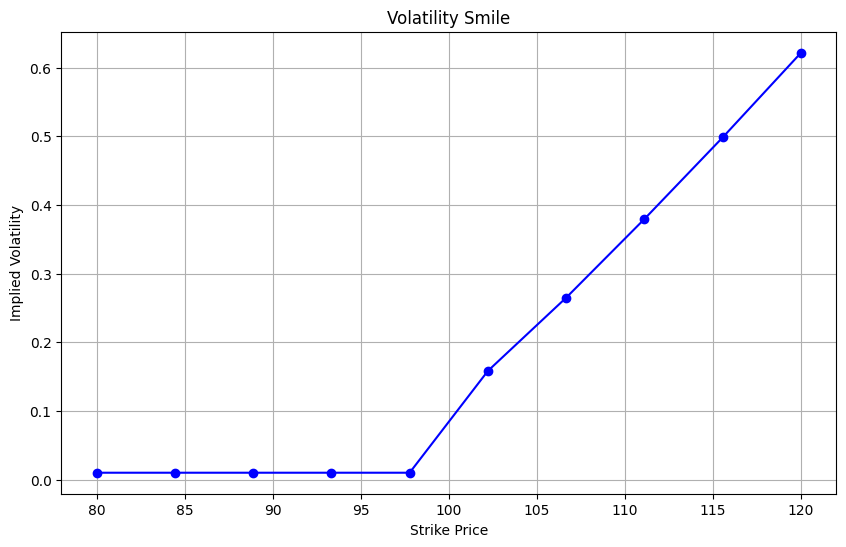

In [43]:
strikes = np.linspace(80, 120, 10)  # Range of strike prices
print([volatility_smile(k) for k in strikes])
market_prices = [bs("Call", s, k, r, vol, T) for k in strikes]
print(market_prices)
market_prices = [bs("Call", s, k, r, volatility_smile(k), T) for k in strikes]
print(market_prices)

# market_prices = np.linspace(5, 15, 10)  # Hypothetical market prices for each strike price

implied_vols = []
for k, market_price in zip(strikes, market_prices):
    vol = implied_volatility_bisection("call", s, k, r, T, market_price)
    implied_vols.append(vol)

# Plot the volatility smile
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, marker='o', color='blue')
plt.title("Volatility Smile")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()